In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import datetime

from helper import make_alphas_state_matrix_with_day_step
from helper import instrument_return, merge_zeros
from helper import AlphaStats, calc_alphas_corr, std
from helper import normalize, neutralize, neutralize_with_dropout

import manipulate_alpha as mpa

from test import test1, test2, test3
from typing import NamedTuple

SLICE_INDEX = 2436

In [2]:
def decay (alpha_matrix, n): # decrease turnover
    
    factors = (np.arange(1, n + 2)) / (n+1)

    _new_alpha_states = alpha_matrix.copy()

    for idx in range(n+1, len(alpha_matrix)):
        _alpha = alpha_matrix[idx-n-1:idx] * np.array([factors]).T
        if not np.array_equal(_alpha, np.zeros_like(_alpha)):
            _new_alpha_states[idx] = _alpha.sum(axis=0)
    
    # return _alpha
    return _new_alpha_states 

In [29]:
def ts_correlation(x, y):
    corr_vec = np.zeros(x.shape[1])

    for idx, (_x, _y) in enumerate(zip(x, y)):
        corr_vec[idx] = calc_alphas_corr(_x, _y)

    return corr_vec

In [3]:
class Alphas_Data(NamedTuple):
    name: str
    cumpnl: np.array

In [4]:
alphas = []

# Creat Dataset

In [5]:
dataset_dir = './USA_2010-2014_HLOCV'
os.listdir(dataset_dir)

['Open.csv', 'High.csv', 'Close.csv', 'Low.csv', 'Volume.csv']

In [6]:
open_df = pd.read_csv(dataset_dir + '/Open.csv')
high_df = pd.read_csv(dataset_dir + '/High.csv')
close_df = pd.read_csv(dataset_dir + '/Close.csv')
low_df = pd.read_csv(dataset_dir + '/Low.csv')
volume_df = pd.read_csv(dataset_dir + '/Volume.csv')

## Mean-reversion alpha

$-ln\frac{open(d)}{close(d-1)}$

In [7]:
day_step = 5

In [8]:
def make_mean_reversion_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(open[day_step:] / close[:-day_step])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [9]:
mean_reversion_alpha = make_mean_reversion_alpha(close_df, open_df, day_step)

# mean_reversion_alpha, zeros_outliers = mpa.CutOutliers(mean_reversion_alpha, 1)
# mean_reversion_alpha, zeros_middles = mpa.CutMiddle(mean_reversion_alpha, 10)

# mean_reversion_alpha = mpa.truncate_alpha(mean_reversion_alpha, 0.05)
# mean_reversion_alpha = decay(mean_reversion_alpha, 10)

# mean_reversion_alpha = mpa.crop(mean_reversion_alpha, 0.1)
# zeros_merged = merge_zeros(zeros_outliers, zeros_middles) 

# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha, zeros_outliers)
# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha,zeros_middles)

mean_reversion_alpha = neutralize(mean_reversion_alpha)
mean_reversion_alpha = normalize(mean_reversion_alpha)

In [10]:
test1(mean_reversion_alpha)
test2(mean_reversion_alpha[day_step:])

Neutrality test passed
Normality test passed


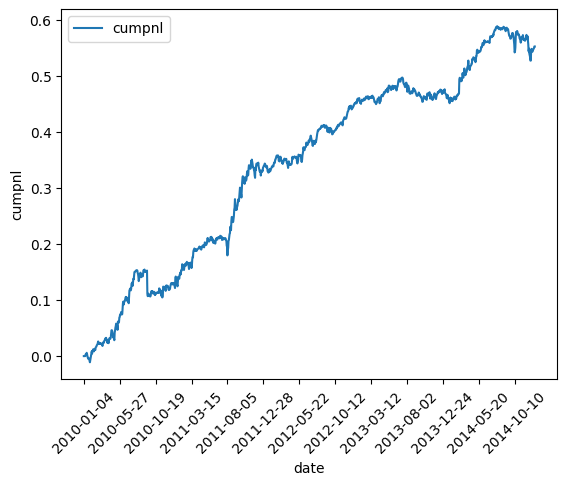

[0.13013280477519074, 0.3397833709379966, 0.4478529330706973, 0.4751585233529981, 0.5534736520708535]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.826766,0.703284,0.049820,0.130133
1,2011,2.661697,0.715459,0.035109,0.339783
2,2012,2.382048,0.712227,0.022373,0.447853
3,2013,0.601442,0.706987,0.043365,0.475159
4,2014,1.197006,0.704996,0.061401,0.553474


In [11]:
mean_rev_alpha_data, mean_rev_alpha_cumpnl = AlphaStats(mean_reversion_alpha, close_df)
mean_rev_alpha_data.head()

In [12]:
test3(mean_rev_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [13]:
alphas.append(Alphas_Data('mean_reverse', mean_rev_alpha_cumpnl))

## Momentum alpha

$ln\frac{close(d-1)}{open(d-1)}$

In [14]:
def make_momentum_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(close[day_step:] / open[day_step:])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [15]:
day_step = 1

momentum_alpha = make_momentum_alpha(close_df, open_df, day_step)
# momentum_alpha, zeros_outliers = mpa.CutOutliers(momentum_alpha, 10)
# momentum_alpha = mpa.truncate_alpha(momentum_alpha, 0.01)
momentum_alpha = decay(momentum_alpha, 10)

# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha, zeros_outliers)
momentum_alpha = neutralize(momentum_alpha)
momentum_alpha = normalize(momentum_alpha)

In [16]:
test1(momentum_alpha)
test2(momentum_alpha[day_step:])

Neutrality test passed
Normality test passed


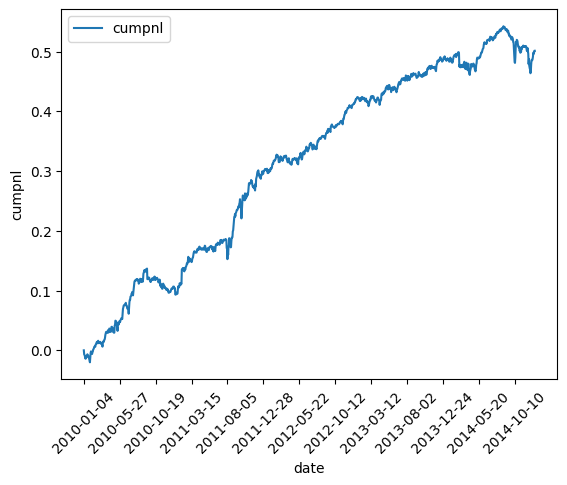

[0.10661293792031856, 0.3002020191697033, 0.41216837396106537, 0.4888151010074261, 0.5013727770371479]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.039785,0.525302,0.040283,0.106613
1,2011,2.744481,0.485311,0.033744,0.300202
2,2012,2.879972,0.477292,0.016937,0.412168
3,2013,1.992797,0.479547,0.015440,0.488815
4,2014,0.199084,0.487745,0.078618,0.501373


In [17]:
momentum_alpha_data, momentum_alpha_cumpnl = AlphaStats(momentum_alpha, close_df)
momentum_alpha_data.head()

In [18]:
test3(momentum_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [19]:
for alpha in alphas:
    print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, momentum_alpha_cumpnl)}')

mean_reverse:	0.9926339585133639


## Alpha 1

(rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) - 0.5)

In [21]:
def make_alpha_1(close_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    return_matrix = instrument_return(close_df)

    alpha = np.zeros((close.shape))

    for i in range(day_step, len(close)):
        alpha[i] += np.where(return_matrix[i] > 0, std(return_matrix[i-day_step:i]), close[i])**2.

    sub_alpha = np.zeros((close.shape))

    for i in range(5, len(alpha)):
        # print(mpa.rank(np.argmax(alpha[i-5:i], axis=0)))
        sub_alpha[i] += np.argmax(alpha[i-5:i], axis=0)# - 0.5

    for i in range(day_step, len(close)):
        alpha[i] = mpa.rank(sub_alpha[i]) - 0.5

    return -alpha

In [22]:
alpha_1 = make_alpha_1(close_df, 20)
# alpha_1, zeros = mpa.CutMiddle(alpha_1, 5)
alpha_1 = mpa.truncate_alpha(alpha_1, 0.03)

In [23]:
# alpha_1 = neutralize_with_dropout(alpha_1, zeros)
alpha_1 = neutralize(alpha_1)
alpha_1 = normalize(alpha_1)

In [24]:
test1(alpha_1)
test2(alpha_1[20:])

Neutrality test passed
Normality test passed


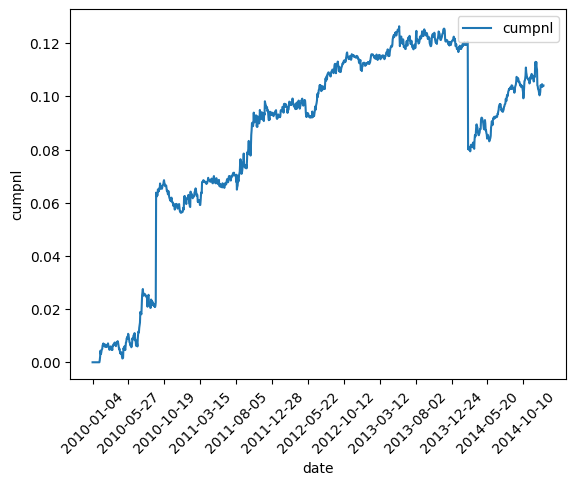

[0.05659399476211514, 0.09343379260853305, 0.11135199820096696, 0.12122458604296424, 0.10410979438241103]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.284688,0.600742,0.012185,0.056594
1,2011,1.562386,0.654827,0.007106,0.093434
2,2012,1.163302,0.639437,0.007223,0.111352
3,2013,0.670318,0.629265,0.008671,0.121225
4,2014,-0.388986,0.643693,0.043141,0.104110


In [25]:
alpha_1_data, alpha_1_cumpnl = AlphaStats(alpha_1, close_df)
alpha_1_data.head()

In [26]:
test3(alpha_1_data)

Sharpe test passed
Turnover test passed
Cumpnl test not passed
passed 2 out of 3 tests


In [27]:
for alpha in alphas:
    print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, alpha_1_cumpnl)}')

mean_reverse:	0.8677169672538532


## Alpha2

(-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))

In [35]:
def make_alpha_2(close_df, open_df, volume_df):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    _alpha = (close - open) / open
    log_vol = np.where(volume != 0, np.log(volume), 0.)
    delta = log_vol[2:] - log_vol[:-2]
    # delta = np.log(volume[2:]) - np.log(volume[:-2])

    sub_alpha = np.zeros_like(_alpha)
    for i in range(len(_alpha)):
        sub_alpha[i] = mpa.rank(_alpha[i])

    sub_delta = np.zeros_like(delta)
    for i in range(len(delta)):
        sub_delta[i] = mpa.rank(delta[i])
    
    alpha = np.zeros_like(delta)
    for i in range(6, len(delta)):
        alpha[i] = -1 * ts_correlation(sub_delta[i-6:i], sub_alpha[2+i-6:2+i])

    return np.concatenate((np.zeros((2, _alpha.shape[1])), alpha))

In [36]:
alpha_2 = make_alpha_2(close_df, open_df, volume_df)

alpha_2 = mpa.truncate_alpha(alpha_2, 35)
# alpha_2, zeros = mpa.CutOutliers(alpha_2, 5)
# alpha_2 = neutralize_with_dropout(alpha_2, zeros)
alpha_2 = neutralize(alpha_2)
alpha_2 = normalize(alpha_2)

test1(alpha_2)
test2(alpha_2[8:])

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_53158/623623427.py:7: RuntimeWarning: divide by zero encountered in log
  log_vol = np.where(volume != 0, np.log(volume), 0.)


Neutrality test passed
Normality test passed


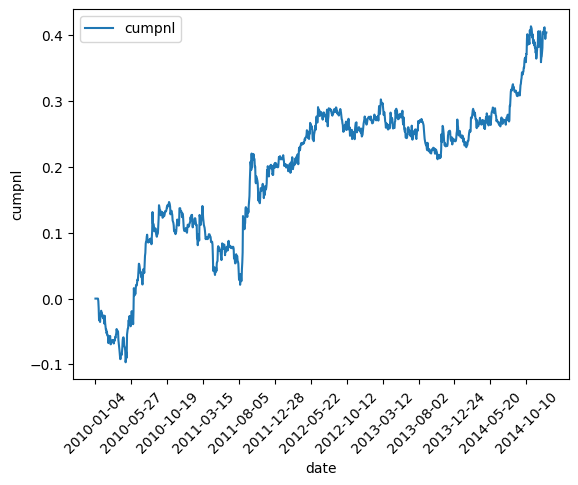

[0.10344481355579625, 0.2060959596678211, 0.2734583987148915, 0.23969840484729088, 0.4043370431567007]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.912552,0.774263,0.096753,0.103445
1,2011,0.742378,0.956714,0.119708,0.206096
2,2012,0.782612,0.838893,0.048731,0.273458
3,2013,-0.384917,0.795023,0.090916,0.239698
4,2014,1.584022,0.882743,0.054556,0.404337


In [37]:
alpha_2_data, alpha_2_cumpnl = AlphaStats(alpha_2, close_df)
alpha_2_data.head()

In [38]:
test3(alpha_2_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test passed
passed 1 out of 3 tests


In [39]:
for alpha in alphas:
    print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, alpha_2_cumpnl)}')

mean_reverse:	0.9281811977109417


# Alpha 3

(-1 * correlation(rank(open), rank(volume), 10))

In [130]:
def make_alpha_3(open_df, volume_df, day_step):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    _open = np.zeros_like(open)
    _volume = np.zeros_like(volume)

    for idx, (x, y) in enumerate(zip(open, volume)):
        _open[idx] = mpa.rank(x)
        _volume[idx] = mpa.rank(y)

    alpha = np.zeros((open.shape))

    for i in range(day_step, len(volume)):
        alpha[i] = -1 * ts_correlation(_open[i-day_step: i], _volume[i-day_step: i])

    return alpha

In [143]:
day_step = 10

alpha_3 = - make_alpha_3(open_df, volume_df, day_step)

alpha_3 = mpa.truncate_alpha(alpha_3, 3)

alpha_3 = neutralize(alpha_3)
alpha_3 = normalize(alpha_3)

test1(alpha_2)
test2(alpha_2[day_step:])

Neutrality test passed
Normality test passed


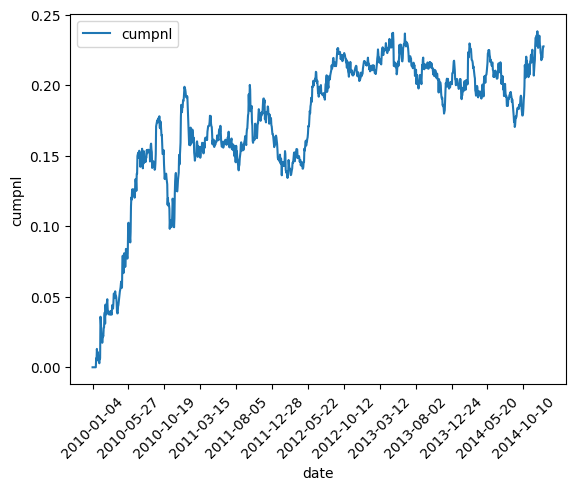

[0.1846421125702086, 0.1653821603838315, 0.20811160221461214, 0.20898418980174527, 0.22768136457576657]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.068841,0.504397,0.079860,0.184642
1,2011,-0.288869,0.444901,0.059282,0.165382
2,2012,0.880658,0.313134,0.031078,0.208112
3,2013,0.016810,0.261934,0.057286,0.208984
4,2014,0.291245,0.308782,0.059249,0.227681


In [144]:
alpha_3_data, alpha_3_cumpnl = AlphaStats(alpha_3, close_df)
alpha_3_data.head()

In [145]:
test3(alpha_3_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [147]:
for alpha in alphas:
    print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, alpha_3_cumpnl)}')

mean_reverse:	0.8251556642631087


## Alpha 4

(-1 * Ts_Rank(rank(low), 9))

In [156]:
def make_alpha_4(low_df, day_step):
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    low_ranked = np.zeros((low.shape))
    for idx, _low in enumerate(low):
        low_ranked[idx] = mpa.rank(_low)

    return np.concatenate((np.zeros((day_step, low_ranked.shape[1])), low_ranked[day_step:]))

In [158]:
day_step = 9

alpha_4 = make_alpha_4(low_df, day_step)

alpha_4 = neutralize(alpha_4)
alpha_4 = normalize(alpha_4)

In [159]:
test1(alpha_4)
test2(alpha_4[day_step:])

Neutrality test passed
Normality test passed


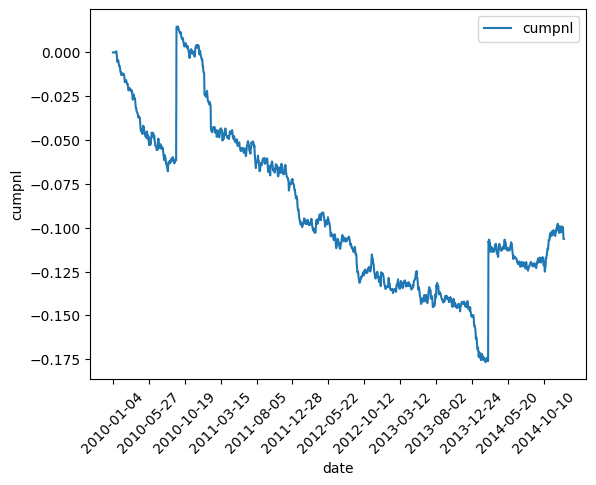

[-0.008078369178105414, -0.07473963007623188, -0.126214156976009, -0.1498360740096109, -0.10645733137687267]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.101658,0.021309,0.068538,-0.008078
1,2011,-2.146137,0.017495,0.070713,-0.074740
2,2012,-2.191522,0.014829,0.058587,-0.126214
3,2013,-0.975063,0.013246,0.026052,-0.149836
4,2014,0.596005,0.013223,0.026887,-0.106457


In [160]:
alpha_4_data, alpha_4_cumpnl = AlphaStats(alpha_4, close_df)
alpha_4_data.head()

In [162]:
test3(alpha_4_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [183]:
for alpha in alphas:
    print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, alpha_4_cumpnl)}')

mean_reverse:	-0.8792450098929371


## Alpha 6

(-1 * correlation(open, volume, 10))

In [185]:
def make_alpha_6(open_df, volume_df, day_step):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros((open.shape))

    for i in range(day_step, len(open)):
        alpha[i] = -1 * ts_correlation(open[i-day_step:i], volume[i-day_step:i])

    return alpha

In [186]:
day_step = 10

alpha_6 = make_alpha_6(open_df, volume_df, day_step)

alpha_6 = neutralize(alpha_6)
alpha_6 = normalize(alpha_6)

alpha_6.shape

(1257, 2436)

In [187]:
test1(alpha_6)
test2(alpha_6)

Neutrality test passed
Normality test is not passed


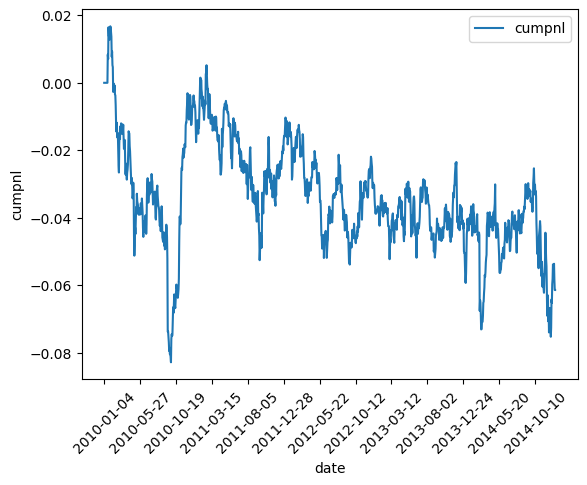

[-0.005393650259294827, -0.015776244220058903, -0.030270958681269822, -0.05037293629188285, -0.061358227341784664]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.099968,0.075045,0.099502,-0.005394
1,2011,-0.202965,0.063140,0.057725,-0.015776
2,2012,-0.363274,0.066375,0.043533,-0.030271
3,2013,-0.464552,0.059464,0.026906,-0.050373
4,2014,-0.202005,0.064519,0.049880,-0.061358


In [188]:
alpha_6_data, alpha_6_cumpnl = AlphaStats(alpha_6, close_df)
alpha_6_data.head()

In [189]:
test3(alpha_6_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [190]:
for alpha in alphas:
    print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, alpha_6_cumpnl)}')

mean_reverse:	-0.5113485326688711


## Alpha 7

((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1 * 1))

In [193]:
def average_dayly_volume(volume, day_step):
    adv = np.zeros_like(volume)

    for i in range(day_step, len(volume)):
        adv[i] = volume[i].mean()

    return adv

In [194]:
def ts_rank(time_series):
    result = np.zeros(time_series.shape[1])

    for i in range(len(result)):
        result[i] = mpa.rank(time_series.T[i])[-1]

    return result

In [203]:
def make_alpha_7(volume_df, close_df):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    
    adv = average_dayly_volume(volume, 20)

    close_delta = np.concatenate((np.zeros((7, close.shape[1])), close[7:] - close[:-7]))

    left = np.zeros_like(volume)
    for i in range(len(left)):
        print(i)
        # left[i] = np.where(adv[i] < volume[i], -1 * ts_rank(np.abs(close_delta)))      
        for j in range(len(left[i])):
            if adv[i][j] < volume[i][j]:
                if i >= 60:
                    left[i][j] = -1 * ts_rank(np.abs(close_delta[i-60:i]))[j] * np.sign(close_delta[i][j])
                else:
                    left[i][j]=0
            else:
                left[i][j] = -1

            print(left[i][j])
                    

    return left
        

In [ ]:
alpha_7 = make_alpha_7(volume_df, close_df)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
_alpha_7 = neutralize(alpha_7)
_alpha_7 = normalize(_alpha_7)

test1(_alpha_7)
test2(_alpha_7[20:])